# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 10)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2024
last_month = 8


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2024-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 54.315,
  'x2': 577.575,
  'y1': 116.00001000000002,
  'y2': 238.40001,
  'width': 523.26,
  'height': 122.4},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 253.000035,
  'y2': 401.41003500000005,
  'width': 519.4350000000001,
  'height': 148.41},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 474.999975,
  'y2': 592.809975,
  'width': 519.4350000000001,
  'height': 117.81},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 56.61,
  'x2': 578.34,
  'y1': 611.000145,
  'y2': 753.290145,
  'width': 521.73,
  'height': 142.29}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[116.00001000000002, 54.315, 238.40001, 577.575],
 [253.000035, 58.14, 401.41003500000005, 577.575],
 [474.999975, 58.14, 592.809975, 577.575],
 [611.000145, 56.61, 753.290145, 578.34]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street     86,831   3,147   2,511   1,784   1,784
  1          9th Street     75,977   2,792   2,108   1,401   1,651
  2         14th Street    127,321   4,834   3,037   2,180   2,472
  3         23rd Street    122,336   5,033   1,964   1,287   1,817
  4         33rd Street    500,254  19,543   9,702   6,865  11,787
  5     UPTOWN SUBTOTAL    912,719  35,350  19,322  13,517  19,510
  6                 WTC    922,430  37,278  15,316  11,296  16,569
  7   NEW YORK SUBTOTAL  1,835,149  72,628  34,638  24,813  36,079,
                       0          1        2       3       4       5
  0               Newark    344,156   14,267   5,102   3,413   5,244
  1             Harrison    130,445    5,417   2,086   1,154   1,862
  2       Journal Square    474,171   18,174  10,822   7,634   9,348
  3         Grove Street    366,378   14,545   7,620   4,638   5,955
  4       Exchange Place    248,376   10,112   4

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables


8

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"86,831","3,147","2,511","1,784","1,784",2024-01-01
1,9th Street,"75,977","2,792","2,108","1,401","1,651",2024-01-01
2,14th Street,"127,321","4,834","3,037","2,180","2,472",2024-01-01
3,23rd Street,"122,336","5,033","1,964","1,287","1,817",2024-01-01
4,33rd Street,"500,254","19,543","9,702","6,865","11,787",2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"290,785","10,937","6,487","4,432",0,2024-08-01
5,Newport,"300,424","11,429","6,227","4,463",0,2024-08-01
6,Hoboken,"417,134","15,764","9,025","6,302",0,2024-08-01
7,NEW JERSEY SUBTOTAL,"2,538,439","95,693","56,061","38,222",0,2024-08-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,86831,3147,2511,1784,1784,2024-01-01
1,9th Street,75977,2792,2108,1401,1651,2024-01-01
2,14th Street,127321,4834,3037,2180,2472,2024-01-01
3,23rd Street,122336,5033,1964,1287,1817,2024-01-01
4,33rd Street,500254,19543,9702,6865,11787,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,290785,10937,6487,4432,0,2024-08-01
5,Newport,300424,11429,6227,4463,0,2024-08-01
6,Hoboken,417134,15764,9025,6302,0,2024-08-01
7,NEW JERSEY SUBTOTAL,2538439,95693,56061,38222,0,2024-08-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,2801,66085,10043,7136,3567,2024-01-01
1,9th Street,2451,58641,8433,5602,3301,2024-01-01
2,14th Street,4107,101507,12149,8721,4944,2024-01-01
3,23rd Street,3946,105700,7855,5147,3634,2024-01-01
4,33rd Street,16137,410413,38806,27461,23574,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,9380,240620,32437,17728,0,2024-08-01
5,Newport,9691,251441,31133,17850,0,2024-08-01
6,Hoboken,13456,346802,45124,25208,0,2024-08-01
7,NEW JERSEY SUBTOTAL,81885,2105247,280305,152887,0,2024-08-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2024-01-01 Christopher Street        2801         3147     2511     1784   
           9th Street                2451         2792     2108     1401   
           14th Street               4107         4834     3037     2180   
           23rd Street               3946         5033     1964     1287   
           33rd Street              16137        19543     9702     6865   
...                                   ...          ...      ...      ...   
2024-08-01 Exchange Place            9380        10937     6487     4432   
           Newport                   9691        11429     6227     4463   
           Hoboken                  13456        15764     9025     6302   
           NEW JERSEY SUBTOTAL      81885        95693    56061    38222   
           MONTHLY TOTAL           150809       175682   103471    73182   

                                avg holiday    total  total weekday  \
month      station                                                    
2024-01-01 Christopher Street          1784    86831          66085   
           9th Street                  1651    75977          58641   
           14th Street                 2472   127321         101507   
           23rd Street                 1817   122336         105700   
           33rd Street                11787   500254         410413   
...                                     ...      ...            ...   
2024-08-01 Exchange Place                 0   290785         240620   
           Newport                        0   300424         251441   
           Hoboken                        0   417134         346802   
           NEW JERSEY SUBTOTAL            0  2538439        2105247   
           MONTHLY TOTAL                  0  4675081        3865000   

                                total sat  total sun  total holiday  
month      station                                                   
2024-01-01 Christopher Street       10043       7136           3567  
           9th Street                8433       5602           3301  
           14th Street              12149       8721           4944  
           23rd Street               7855       5147           3634  
           33rd Street              38806      27461          23574  
...                                   ...        ...            ...  
2024-08-01 Exchange Place           32437      17728              0  
           Newport                  31133      17850              0  
           Hoboken                  45124      25208              0  
           NEW JERSEY SUBTOTAL     280305     152887              0  
           MONTHLY TOTAL           517355     292726              0  

[136 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

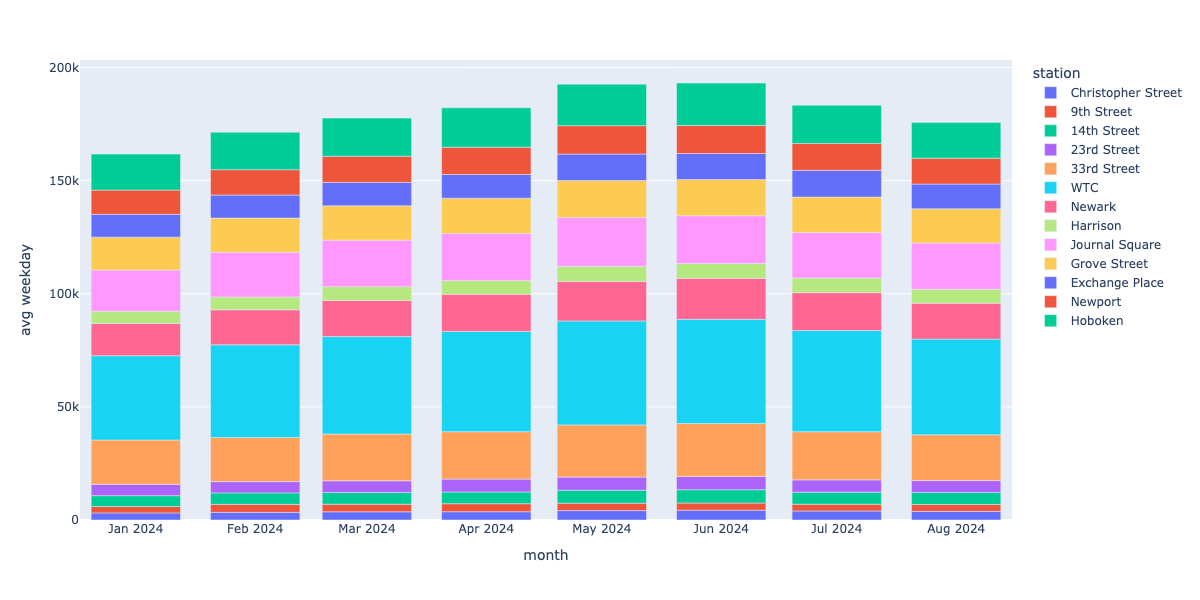

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))